In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!nvidia-smi

Wed Jun  8 16:25:16 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
pip install underthesea

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.6 MB 11.6 MB/s 
     |████████████████████████████████| 965 kB 19.8 MB/s 
     |████████████████████████████████| 235 kB 53.8 MB/s 
     |████████████████████████████████| 581 kB 8.0 MB/s 


In [4]:
%tensorflow_version 2.x

In [5]:
import pandas as pd
from itertools import chain
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import io
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import string
import re
from os.path import join
from underthesea import sent_tokenize,word_tokenize,pos_tag
from sklearn.metrics import *
from sklearn.utils.class_weight import compute_class_weight
from gensim.models import Word2Vec
from collections import Counter
import matplotlib.pyplot as plt

In [6]:
train=pd.read_csv("/content/drive/MyDrive/vietnamese_students_feedback/raw_dataset/train.csv")

In [7]:
valid=pd.read_csv("/content/drive/MyDrive/vietnamese_students_feedback/raw_dataset/valid.csv")

In [8]:
re.sub(r'\d',' ',"m4234l23ml423.4.23/4.324")

'm    l  ml   . .  / .   '

In [9]:
punctuations=list(string.punctuation)
def normalizer(text,joinf=False):
  def remove_symbols(s):
    return re.sub(r'\b(colon\w+)\b'," ",s)

  def remove_fraction(s):
    return re.sub(r'\b(fraction)\b','/',s)

  def replace_dot(s):
    return s.replace('dot','.')
    # return re.sub(r'\b(dot)\b',".",s)

  def replace_doubledot(s):
    return s.replace('doubledot',':')
    
  def uncased(s):
    return s.lower()

  def fix_whitespaces(s):
    return re.sub(r'\s+',' ',s)

  def remove_entities(s):
    return re.sub(r'\b((\w+|)wzjwz\d+)\b'," ",s)
  def remove_numbers(s):
    return re.sub(r'\d',' ',s)
  def remove_vv(s):
    return s.replace('v.v'," ")

  def remove_punctuations(s):
      return ''.join(ch for ch in s if ch not in punctuations)
  def norm_major(s):
      majors={
          'cnpm':"công nghệ phần mềm",
          'khmt':"khoa học máy tính",
          'ktmt':"kĩ thuật máy tính",
          'cntt':"công nghệ thông tin",
          'av1':"anh văn 1",
          'av2':"anh văn 2",
          'av3':"anh văn 3"
      }
      for k,v in majors.items():
        s=re.sub(r'\b({})\b'.format(k),v,s)
      return s
  def remove_ps(s):
    return s.replace("p / s"," ")

  def tokenizer(text):
    tokens=[]
    pos_tags=[]
    for sent in sent_tokenize(text):
      tags=pos_tag(remove_punctuations(sent))
      for token in tags:
          tokens.append(uncased(token[0]))
          pos_tags.append(f'{uncased(token[0])}|{token[1]}')
          
    return tokens,pos_tags

  norm_text=fix_whitespaces(remove_numbers(norm_major(remove_ps(remove_fraction(remove_vv(remove_entities(remove_symbols(replace_dot(replace_doubledot(text))))))))).strip())
  return tokenizer(norm_text)

In [10]:
train_x=train['sentence'].tolist()
train_y=train['topic'].tolist()

In [11]:
train_x=[normalizer(sample)for sample in train_x]

In [12]:
train_x[0]

(['slide', 'giáo trình', 'đầy đủ'], ['slide|N', 'giáo trình|V', 'đầy đủ|A'])

In [13]:
all_tokens=[s[0] for s in train_x]
all_tokens=list(chain.from_iterable(all_tokens))

In [14]:
counter=Counter(all_tokens)

In [15]:
counter.most_common(10)

[('thầy', 3044),
 ('sinh viên', 2683),
 ('dạy', 2162),
 ('và', 2068),
 ('không', 2061),
 ('rất', 1961),
 ('nhiệt tình', 1822),
 ('cho', 1724),
 ('có', 1709),
 ('hiểu', 1639)]

In [16]:
x,y=list(range(1,len(counter)+1)),list(counter.values())


In [17]:
def seq_len_visualizer(x,y):
  fig, ax = plt.subplots(1, 1, sharex=True, sharey=True,figsize=(5,5))
  ax.bar(x,y)
  fig.show()

(None, 3395, 1)

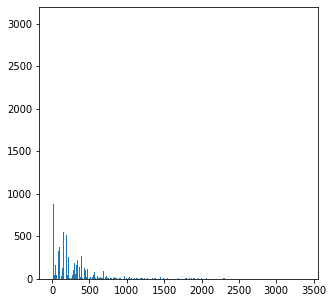

In [18]:
seq_len_visualizer(x,y),max(x),min(x)

In [19]:
all_pos_tags=[s[1] for s in train_x]
all_pos_tags=list(chain.from_iterable(all_pos_tags))

In [20]:
counter=Counter(all_pos_tags)

In [21]:
counter.most_common(10)

[('thầy|N', 3044),
 ('sinh viên|N', 2681),
 ('dạy|V', 2162),
 ('và|C', 2068),
 ('không|R', 2061),
 ('rất|R', 1961),
 ('có|V', 1705),
 ('hiểu|V', 1639),
 ('nhiều|A', 1621),
 ('cho|E', 1464)]

In [22]:
x,y=list(range(1,len(counter)+1)),list(counter.values())

In [23]:
def seq_len_visualizer(x,y):
  fig, ax = plt.subplots(1, 1, sharex=True, sharey=True,figsize=(5,5))
  ax.bar(x,y)
  fig.show()

(None, 4640, 1)

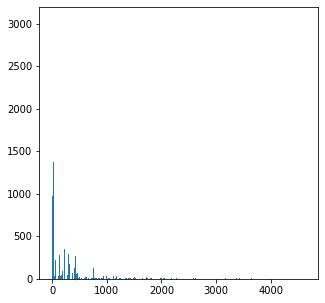

In [24]:
seq_len_visualizer(x,y),max(x),min(x)

#Train word2vec

In [25]:
min_count=1
window=3
size=300
alpha=1e-3
min_alpha=1e-4
negative=10
w2v_model = Word2Vec(min_count=min_count,window=window,size=size,alpha=alpha,min_alpha=min_alpha,negative=negative,sg=1)

In [26]:
word_sents=[sent[0] for sent in train_x]

In [27]:
w2v_model.build_vocab(word_sents)
w2v_model.train(word_sents, total_examples=w2v_model.corpus_count, epochs=100, report_delay=1,compute_loss=True)

(7590164, 10900200)

In [28]:
w2v_model.get_latest_training_loss()

21437636.0

In [29]:
w2v_model.wv.most_similar(word_sents[0][0]),word_sents[0][0]

([('bài giảng', 0.9062808752059937),
  ('đọc', 0.8974524736404419),
  ('giáo trình', 0.8962157368659973),
  ('giao tiếp', 0.8772605657577515),
  ('việt', 0.873903751373291),
  ('bằng', 0.8690881133079529),
  ('rõ ràng', 0.852863073348999),
  ('chữ', 0.8478755354881287),
  ('to', 0.8409874439239502),
  ('nữa', 0.8406916856765747)],
 'slide')

In [30]:
wv=w2v_model.wv

In [31]:
vocabs=['pad','unk']+list(wv.vocab.keys())

In [32]:
vocab2idx={vocab:idx for idx,vocab in enumerate(vocabs)}

In [33]:
min_count=1
window=3
size=300
alpha=1e-3
min_alpha=1e-4
negative=10
p2v_model = Word2Vec(min_count=min_count,window=window,size=size,alpha=alpha,min_alpha=min_alpha,negative=negative,sg=1)

In [34]:
pos_sents=[sent[1] for sent in train_x]

In [35]:
p2v_model.build_vocab(pos_sents)

In [36]:
p2v_model.train(pos_sents, total_examples=p2v_model.corpus_count, epochs=100, report_delay=1,compute_loss=True)

(7874040, 10900200)

In [37]:
p2v_model.get_latest_training_loss()

23331022.0

In [38]:
p2v_model.wv.most_similar(pos_sents[0][0]),pos_sents[0][0]

([('giao tiếp|V', 0.9270137548446655),
  ('giáo trình|N', 0.9210951328277588),
  ('đọc|V', 0.9182546138763428),
  ('bài giảng|V', 0.91619473695755),
  ('rõ ràng|A', 0.9109913110733032),
  ('việt|V', 0.9108653664588928),
  ('to|A', 0.907416820526123),
  ('việt|M', 0.9073805809020996),
  ('luyện|V', 0.9037903547286987),
  ('bằng|E', 0.9022912979125977)],
 'slide|N')

In [39]:
pv=p2v_model.wv

In [40]:
pos_tags=['pad','unk']+list(pv.vocab.keys())

In [41]:
len(vocabs),len(pos_tags)

(3397, 4642)

In [42]:
pos2idx={pos:idx for idx,pos in enumerate(pos_tags)}

In [45]:
w_weights=np.concatenate([np.random.uniform(low=-0.05,high=0.05,size=(2,300)),wv.vectors],axis=0)
w_weights.shape

(3397, 300)

In [46]:
p_weights=np.concatenate([np.random.uniform(low=-0.05,high=0.05,size=(2,300)),pv.vectors],axis=0)
p_weights.shape

(4642, 300)

#Create inputs

In [47]:
def create_input_ids(sample):
  _tokens=[]
  _pos_tags=[]
  tokens,pos_tags=normalizer(sample)

  for i in zip(tokens,pos_tags):
    if i[0] in vocab2idx:
      _tokens.append(vocab2idx[i[0]])
    else:
      _tokens.append(vocab2idx['unk'])

    if i[1] in pos2idx:
      _pos_tags.append(pos2idx[i[1]])
    else:
      _pos_tags.append(pos2idx['unk'])

  return _tokens,_pos_tags

In [48]:
train_x=train['sentence'].tolist()
train_y=train['topic'].tolist()

In [49]:
create_input_ids(train_x[0]),train_x[0]

(([2, 3, 4], [2, 3, 4]), 'slide giáo trình đầy đủ .')

In [50]:
train_x=[create_input_ids(s) for s in train_x]

In [51]:
words_train_x=[s[0] for s in train_x]
pos_tags_train_x=[s[1] for s in train_x]

In [57]:
max([len(s)for s in words_train_x])

128

In [58]:
max_length=128

In [59]:
words_train_x = tf.keras.preprocessing.sequence.pad_sequences(
    words_train_x, padding="post",maxlen=max_length)

pos_tags_train_x = tf.keras.preprocessing.sequence.pad_sequences(
    pos_tags_train_x, padding="post",maxlen=max_length)

In [60]:
valid_x=valid['sentence'].tolist()
valid_y=valid['topic'].tolist()

In [61]:
valid_x=[create_input_ids(s) for s in valid_x]

In [62]:
words_valid_x=[s[0] for s in valid_x]
pos_tags_valid_x=[s[1] for s in valid_x]

In [63]:
words_valid_x = tf.keras.preprocessing.sequence.pad_sequences(
    words_valid_x, padding="post",maxlen=max_length)

pos_tags_valid_x = tf.keras.preprocessing.sequence.pad_sequences(
    pos_tags_valid_x, padding="post",maxlen=max_length)

In [64]:
train_batch_size=16
train_dataloader=tf.data.Dataset.from_tensor_slices({'input_ids':words_train_x,'pos_ids':pos_tags_train_x,'labels':train_y})
train_dataloader=train_dataloader.batch(batch_size=train_batch_size)

In [65]:
valid_batch_size=16
valid_dataloader=tf.data.Dataset.from_tensor_slices({'input_ids':words_valid_x,'pos_ids':pos_tags_valid_x,'labels':valid_y})
valid_dataloader=valid_dataloader.batch(batch_size=valid_batch_size)

#Define model

In [173]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [213]:
LSTM_Layer = tf.compat.v1.keras.layers.CuDNNLSTM if tf.test.gpu_device_name()!="" else layers.LSTM
LSTM_Layer


keras.layers.cudnn_recurrent.CuDNNLSTM

In [215]:
class BiLSTMClassificier(tf.keras.Model):
  def __init__(self,embedding_dim,hidden_dim,num_vocabs,num_pos_tags,num_labels,drop_rate=0.1,word_embedding_weights=None,pos_embedding_weights=None):
    super(BiLSTMClassificier,self).__init__()

    self.embedding_dim=embedding_dim
    self.hidden_dim=hidden_dim
    self.num_vocabs=num_vocabs
    self.num_labels=num_labels
    self.drop_rate=drop_rate
    self.num_pos_tags=num_pos_tags
    self.word_embedding_weights=word_embedding_weights
    self.pos_embedding_weights=pos_embedding_weights

    if self.word_embedding_weights is not None:
      self.word_embedding_layer=layers.Embedding(self.num_vocabs,self.embedding_dim,
                                                  embeddings_initializer=tf.keras.initializers.Constant(self.word_embedding_weights),trainable=True)
    else:
      self.word_embedding_layer=layers.Embedding(self.num_vocabs,self.embedding_dim,trainable=True)

    if self.pos_embedding_weights is not None:
      self.pos_embedding_layer=layers.Embedding(self.num_pos_tags,self.embedding_dim,
                                                  embeddings_initializer=tf.keras.initializers.Constant(self.pos_embedding_weights),trainable=True)
    else:
      self.pos_embedding_layer=layers.Embedding(self.num_pos_tags,self.embedding_dim,trainable=True)

    # self.embedding_layer=layers.Concatenate(axis=-1)

    self.forward_lstm_layer=LSTM_Layer(self.hidden_dim)

    self.backward_lstm_layer=LSTM_Layer(self.hidden_dim,go_backwards=True)

    self.bi_lstm_layer=layers.Bidirectional(layer=self.forward_lstm_layer,backward_layer=self.backward_lstm_layer)

    self.dropout_layer=layers.Dropout(self.drop_rate)

    self.linear=layers.Dense(self.num_labels)


  def call(self,input_ids,pos_ids,training=False):

    #shape of x: (batch_size,seq_len)

    word_embedding=self.word_embedding_layer(input_ids)
    pos_embedding=self.pos_embedding_layer(pos_ids)
    # embedding_inputs=self.embedding_layer([word_embedding,pos_embedding])
    embedding_inputs=word_embedding+pos_embedding


    # forward_lstm_inputs=self.forward_lstm_layer(embedding_inputs)
    # backward_lstm_inputs=self.backward_lstm_layer(embedding_inputs)
    bi_lstm_outputs=self.bi_lstm_layer(embedding_inputs)

    
    bi_lstm_outputs=self.dropout_layer(bi_lstm_outputs,training=training)

    logits=self.linear(bi_lstm_outputs)

    return logits

    

In [216]:
embedding_dim=300
hidden_dim=128
num_vocabs=len(vocabs)
num_pos_tags=len(pos_tags)
num_labels=4
drop_rate=0.4

model=BiLSTMClassificier(embedding_dim,hidden_dim,num_vocabs,num_pos_tags,num_labels,
                         drop_rate=drop_rate,word_embedding_weights=w_weights,pos_embedding_weights=p_weights)

In [217]:
for batch in train_dataloader:
  print(batch)
  break

{'input_ids': <tf.Tensor: shape=(16, 128), dtype=int32, numpy=
array([[  2,   3,   4, ...,   0,   0,   0],
       [  5,   6,   7, ...,   0,   0,   0],
       [ 10,  11,   4, ...,   0,   0,   0],
       ...,
       [ 65, 100,  92, ...,   0,   0,   0],
       [104,  23,   9, ...,   0,   0,   0],
       [117, 118, 119, ...,   0,   0,   0]], dtype=int32)>, 'pos_ids': <tf.Tensor: shape=(16, 128), dtype=int32, numpy=
array([[  2,   3,   4, ...,   0,   0,   0],
       [  5,   6,   7, ...,   0,   0,   0],
       [ 10,  11,   4, ...,   0,   0,   0],
       ...,
       [ 65, 102,  94, ...,   0,   0,   0],
       [106, 107,   9, ...,   0,   0,   0],
       [120, 121, 122, ...,   0,   0,   0]], dtype=int32)>, 'labels': <tf.Tensor: shape=(16,), dtype=int32, numpy=array([1, 0, 1, 0, 0, 0, 3, 1, 1, 1, 0, 3, 0, 1, 1, 3], dtype=int32)>}


In [218]:
for batch in valid_dataloader:
  print(batch)
  break

{'input_ids': <tf.Tensor: shape=(16, 128), dtype=int32, numpy=
array([[   3,   16,  153, ...,    0,    0,    0],
       [  26,  281,    0, ...,    0,    0,    0],
       [ 300,  278,  224, ...,    0,    0,    0],
       ...,
       [ 457, 1449,    0, ...,    0,    0,    0],
       [ 113,   77,  715, ...,    0,    0,    0],
       [ 212,   89,   75, ...,    0,    0,    0]], dtype=int32)>, 'pos_ids': <tf.Tensor: shape=(16, 128), dtype=int32, numpy=
array([[322,  16, 161, ...,   0,   0,   0],
       [234, 302,   0, ...,   0,   0,   0],
       [325, 298, 643, ...,   0,   0,   0],
       ...,
       [503,   1,   0, ...,   0,   0,   0],
       [116, 154, 812, ...,   0,   0,   0],
       [224,  91,  75, ...,   0,   0,   0]], dtype=int32)>, 'labels': <tf.Tensor: shape=(16,), dtype=int32, numpy=array([1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0], dtype=int32)>}


In [219]:
# lr=1e-5
# epsilon=1e-8
# # decay=0
# optimizer=tf.keras.optimizers.Adam(learning_rate=lr,epsilon=epsilon)

optimizer=tf.keras.optimizers.SGD(learning_rate=0.02)

In [220]:
class_weight=tf.constant(compute_class_weight(class_weight='balanced',y=train_y,classes=[0,1,2,3]),dtype=tf.float32)

In [221]:
class_weight

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.34980407, 1.2978191 , 5.7474847 , 5.0827403 ], dtype=float32)>

In [222]:
loss_fn=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)#,reduction=tf.keras.losses.Reduction.NONE)

In [223]:
train_step_signature= [
    tf.TensorSpec(shape=(None, None), dtype=tf.int32),
    tf.TensorSpec(shape=(None, None), dtype=tf.int32),
    tf.TensorSpec(shape=(None, ), dtype=tf.int32),
]


@tf.function(input_signature=train_step_signature)
def train_step(input_ids,pos_ids,labels):
  
  with tf.GradientTape() as tape:

    logits= model(input_ids=input_ids,pos_ids=pos_ids,training = True)
    probs=tf.nn.softmax(logits,axis=-1)
    # weighted_logits=tf.multiply(probs,class_weight)
    loss=loss_fn(labels,probs)
    
    # loss=tf.multiply(losses,sample_weight)
    # loss=tf.reduce_mean(loss,axis=-1)



  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss,probs

In [224]:
def test_step(input_ids,pos_ids,labels):
  logits= model(input_ids=input_ids,pos_ids=pos_ids,training = False)

  probs=tf.nn.softmax(logits,axis=-1)
  # weighted_logits=tf.multiply(probs,class_weight)
  loss=loss_fn(labels,probs)
  # loss=tf.multiply(losses,sample_weight)
  # loss=tf.reduce_mean(loss,axis=-1)

  return loss,probs

In [225]:
ckpt_path = "/content/drive/MyDrive/vietnamese_students_feedback/models/last-hidden"
max_to_keep=5

ckpt = tf.train.Checkpoint(model=model,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, ckpt_path, max_to_keep=max_to_keep)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print(f'Loading the latest checkpoint from {ckpt_manager.latest_checkpoint}')
else:
  print('Initializing the new checkpoint')

Initializing the new checkpoint


#Train

In [226]:
epochs=100

In [227]:
# min_loss=np.inf
best_acc=0
train_losses=[]
valid_losses=[]
train_accs=[]
valid_accs=[]
count_stopping=0

for epoch in range(epochs):
  bar=tqdm(train_dataloader)

  """TRAINING"""
  train_loss=0
  y_true=[]
  y_pred=[]
  for batch in train_dataloader:
    y_true.append(batch['labels'].numpy())
    loss,probs=train_step(batch['input_ids'],batch['pos_ids'],batch['labels'])
    loss=loss.numpy()
    train_loss+=loss
    pred=tf.argmax(probs,axis=-1)
    
    y_pred.append(pred.numpy())
    bar.set_postfix({f'train_loss_per_batch':loss})
    bar.update()
  
  train_loss/=len(train_dataloader)
  y_true=np.concatenate(y_true,axis=0)
  y_pred=np.concatenate(y_pred,axis=0)
  train_acc=f1_score(y_true,y_pred,average='macro')

  """Validation"""
  valid_loss=0
  y_true=[]
  y_pred=[]
  for batch in valid_dataloader:
    y_true.append(batch['labels'].numpy())
    loss,probs=test_step(batch['input_ids'],batch['pos_ids'],batch['labels'])
    pred=tf.argmax(probs,axis=-1)
    y_pred.append(pred.numpy())
    loss=loss.numpy()
    valid_loss+=loss
  valid_loss/=len(valid_dataloader)
  y_true=np.concatenate(y_true,axis=0)
  y_pred=np.concatenate(y_pred,axis=0)
  valid_acc=f1_score(y_true,y_pred,average='macro')
  print(f'epoch: {epoch} train_loss: {train_loss} train_acc: {train_acc} valid_loss: {valid_loss} valid_acc: {valid_acc}')
  
  # if min_loss>valid_loss:
  if best_acc<valid_acc:
    ckpt_save_path = ckpt_manager.save()
    print(f'Saving checkpoint for epoch {epoch} at {ckpt_save_path}')
    best_acc=valid_acc
    # min_loss=valid_loss
    count_stopping=0
  else:
    count_stopping+=1

  train_losses.append(train_loss)
  valid_losses.append(valid_loss)

  train_accs.append(train_acc)
  valid_accs.append(valid_acc)

  if count_stopping>5:
    break

  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 0 train_loss: 0.7955464117176883 train_acc: 0.22101841027024904 valid_loss: 0.7687943389620444 valid_acc: 0.21049743964886614
Saving checkpoint for epoch 0 at /content/drive/MyDrive/vietnamese_students_feedback/models/last-hidden/ckpt-1


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 1 train_loss: 0.6844668876978901 train_acc: 0.29644465670408165 valid_loss: 0.6737967484226131 valid_acc: 0.22357046423089222
Saving checkpoint for epoch 1 at /content/drive/MyDrive/vietnamese_students_feedback/models/last-hidden/ckpt-2


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 2 train_loss: 0.5937933762955082 train_acc: 0.3553925117874622 valid_loss: 0.5941623200972875 valid_acc: 0.28631731994987725
Saving checkpoint for epoch 2 at /content/drive/MyDrive/vietnamese_students_feedback/models/last-hidden/ckpt-3


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 3 train_loss: 0.5347510545091195 train_acc: 0.3860783160914286 valid_loss: 0.5343244029114945 valid_acc: 0.35152905470164353
Saving checkpoint for epoch 3 at /content/drive/MyDrive/vietnamese_students_feedback/models/last-hidden/ckpt-4


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 4 train_loss: 0.500964827147814 train_acc: 0.4132091506744391 valid_loss: 0.5258645948888075 valid_acc: 0.3502817976345388


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 5 train_loss: 0.47751204468883 train_acc: 0.4314175388395335 valid_loss: 0.4870261565753908 valid_acc: 0.3729786396966893
Saving checkpoint for epoch 5 at /content/drive/MyDrive/vietnamese_students_feedback/models/last-hidden/ckpt-5


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 6 train_loss: 0.4542669568549503 train_acc: 0.48863271286509935 valid_loss: 0.48234474884741235 valid_acc: 0.4033410589243173
Saving checkpoint for epoch 6 at /content/drive/MyDrive/vietnamese_students_feedback/models/last-hidden/ckpt-6


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 7 train_loss: 0.42959958599111836 train_acc: 0.5816682676989798 valid_loss: 0.43771471745438045 valid_acc: 0.5279711237484944
Saving checkpoint for epoch 7 at /content/drive/MyDrive/vietnamese_students_feedback/models/last-hidden/ckpt-7


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 8 train_loss: 0.41124946383329536 train_acc: 0.633462919391437 valid_loss: 0.4153927430661038 valid_acc: 0.5958694800863553
Saving checkpoint for epoch 8 at /content/drive/MyDrive/vietnamese_students_feedback/models/last-hidden/ckpt-8


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 9 train_loss: 0.39246204148430924 train_acc: 0.6618287132222043 valid_loss: 0.4129217158288065 valid_acc: 0.6196855475475442
Saving checkpoint for epoch 9 at /content/drive/MyDrive/vietnamese_students_feedback/models/last-hidden/ckpt-9


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 10 train_loss: 0.3805454060956315 train_acc: 0.6795841421572162 valid_loss: 0.3988537171272316 valid_acc: 0.6562549269953172
Saving checkpoint for epoch 10 at /content/drive/MyDrive/vietnamese_students_feedback/models/last-hidden/ckpt-10


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 11 train_loss: 0.36933695561272073 train_acc: 0.6932674210773092 valid_loss: 0.3906437172131105 valid_acc: 0.6687530256627862
Saving checkpoint for epoch 11 at /content/drive/MyDrive/vietnamese_students_feedback/models/last-hidden/ckpt-11


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 12 train_loss: 0.35824647368928353 train_acc: 0.7033926796091823 valid_loss: 0.38215097096381767 valid_acc: 0.6889703616457901
Saving checkpoint for epoch 12 at /content/drive/MyDrive/vietnamese_students_feedback/models/last-hidden/ckpt-12


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 13 train_loss: 0.3506051964927595 train_acc: 0.7165029157566274 valid_loss: 0.37862451359479116 valid_acc: 0.6881482848259525


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 14 train_loss: 0.3441871625403841 train_acc: 0.7268775083836109 valid_loss: 0.38027749282091555 valid_acc: 0.6978589445465772
Saving checkpoint for epoch 14 at /content/drive/MyDrive/vietnamese_students_feedback/models/last-hidden/ckpt-13


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 15 train_loss: 0.33711920415630914 train_acc: 0.7341146019430246 valid_loss: 0.37147754852217857 valid_acc: 0.7126310917953111
Saving checkpoint for epoch 15 at /content/drive/MyDrive/vietnamese_students_feedback/models/last-hidden/ckpt-14


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 16 train_loss: 0.32958283819310313 train_acc: 0.7374230077113915 valid_loss: 0.37820622964639855 valid_acc: 0.7007097436923515


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 17 train_loss: 0.3242978518151424 train_acc: 0.7472787732174004 valid_loss: 0.36860746958039026 valid_acc: 0.7248347115492497
Saving checkpoint for epoch 17 at /content/drive/MyDrive/vietnamese_students_feedback/models/last-hidden/ckpt-15


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 18 train_loss: 0.31696007383622593 train_acc: 0.7549112248609144 valid_loss: 0.3690811001291179 valid_acc: 0.7239210282361688


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 19 train_loss: 0.3114107436754487 train_acc: 0.7658174452403775 valid_loss: 0.36351020502472164 valid_acc: 0.7344900328236638
Saving checkpoint for epoch 19 at /content/drive/MyDrive/vietnamese_students_feedback/models/last-hidden/ckpt-16


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 20 train_loss: 0.30551514173304284 train_acc: 0.773313787999435 valid_loss: 0.36930351384510895 valid_acc: 0.7240472748865601


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 21 train_loss: 0.3040486562463058 train_acc: 0.7732770497076062 valid_loss: 0.37091327289288695 valid_acc: 0.7275544233011267


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 22 train_loss: 0.29550611937379506 train_acc: 0.7817947188044302 valid_loss: 0.365319707929486 valid_acc: 0.7307675425516527


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 23 train_loss: 0.29201327183420633 train_acc: 0.7887930965212847 valid_loss: 0.3694629241345507 valid_acc: 0.7345845536114686
Saving checkpoint for epoch 23 at /content/drive/MyDrive/vietnamese_students_feedback/models/last-hidden/ckpt-17


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 24 train_loss: 0.2891410618759952 train_acc: 0.7910634373406769 valid_loss: 0.3783410003013683 valid_acc: 0.725381831509799


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 25 train_loss: 0.2847413117600071 train_acc: 0.7945383885586071 valid_loss: 0.3648975584091562 valid_acc: 0.7504229477802091
Saving checkpoint for epoch 25 at /content/drive/MyDrive/vietnamese_students_feedback/models/last-hidden/ckpt-18


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 26 train_loss: 0.28120820995459295 train_acc: 0.796132811162189 valid_loss: 0.3697522249486711 valid_acc: 0.7370424056972292


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 27 train_loss: 0.27527608073713794 train_acc: 0.8016916897301783 valid_loss: 0.3728962500363287 valid_acc: 0.7418984962406016


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 28 train_loss: 0.2716607085657078 train_acc: 0.8068401004565284 valid_loss: 0.3826272105704052 valid_acc: 0.7413432736937944


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 29 train_loss: 0.26873035505804777 train_acc: 0.807776749622383 valid_loss: 0.37239542976021767 valid_acc: 0.7402197245795624


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 30 train_loss: 0.26408950128963776 train_acc: 0.8160434941784949 valid_loss: 0.3851084207570312 valid_acc: 0.7403234508391348


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 31 train_loss: 0.2584508888924924 train_acc: 0.8235842283842219 valid_loss: 0.3830902194133913 valid_acc: 0.7344546913139222


#Visualize

In [228]:
def visualizer(x,y,y_label):
  fig,ax=plt.subplots(1,1)
  ax.plot(x)
  ax.plot(y)
  ax.set_xlabel('epoch')
  ax.set_ylabel(y_label)
  
  # ax2.plot(valid_losses)
  # ax2.set_xlabel('epoch')
  # ax2.set_ylabel('valid_loss')
  
  fig.show()

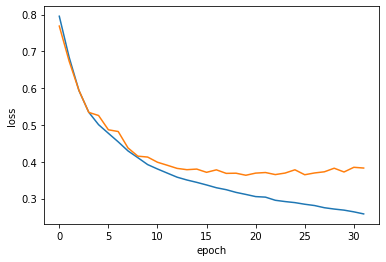

In [229]:
visualizer(train_losses,valid_losses,'loss')

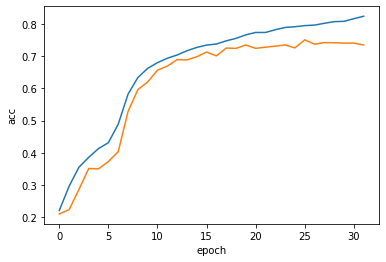

In [230]:
visualizer(train_accs,valid_accs,'acc')

#Inference

In [231]:
test=pd.read_csv("/content/drive/MyDrive/vietnamese_students_feedback/raw_dataset/test.csv")

In [232]:
test_x=test['sentence'].tolist()
test_y=test['topic'].tolist()

In [233]:
embedding_dim=300
hidden_dim=128
num_vocabs=len(vocabs)
num_pos_tags=len(pos_tags)
num_labels=4
drop_rate=0.1

model=BiLSTMClassificier(embedding_dim,hidden_dim,num_vocabs,num_pos_tags,num_labels,
                         drop_rate=drop_rate)

In [234]:
ckpt_path = "/content/drive/MyDrive/vietnamese_students_feedback/models/last-hidden/"
max_to_keep=5

ckpt = tf.train.Checkpoint(model=model,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, ckpt_path, max_to_keep=max_to_keep)

In [235]:
# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print(f'Loading the latest checkpoint from {ckpt_manager.latest_checkpoint}')
else:
  print('Initializing the new checkpoint')

Loading the latest checkpoint from /content/drive/MyDrive/vietnamese_students_feedback/models/last-hidden/ckpt-18


In [236]:
test_pred=[]
bar=tqdm(test_x)
for sample in test_x:

  inputs=[create_input_ids(sample)]
  input_ids=tf.constant([i[0] for i in inputs],dtype=tf.int32)
  pos_ids=tf.constant([i[1] for i in inputs],dtype=tf.int32)

  
  
  logits=model(input_ids=input_ids,pos_ids=pos_ids,training=False)
  probs=tf.nn.softmax(logits,axis=-1)
  label=tf.argmax(probs,axis=-1)
  test_pred.append(label.numpy())
  bar.update()
  

  0%|          | 0/3166 [00:00<?, ?it/s]

In [237]:
print(classification_report(test_y,test_pred,digits=5))

              precision    recall  f1-score   support

           0    0.91279   0.95066   0.93134      2290
           1    0.74312   0.70804   0.72516       572
           2    0.76437   0.91724   0.83386       145
           3    0.56452   0.22013   0.31674       159

    accuracy                        0.86860      3166
   macro avg    0.74620   0.69902   0.70177      3166
weighted avg    0.85785   0.86860   0.85876      3166



In [238]:
confusion_matrix(test_y,test_pred)

array([[2177,   91,   10,   12],
       [ 139,  405,   13,   15],
       [   4,    8,  133,    0],
       [  65,   41,   18,   35]])

Future works
- Need to clean data
- Improve pretrained word embedding